In [ ]:
import cv2
import numpy as np
import pandas as pd
import random


def load_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open video file: {video_path}")
    else:
        ret, frame = cap.read()
        if not ret:
            cap.release()
            raise ValueError(f"Could not read frame from video file: {video_path}")
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return frame_rgb



def preprocess_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    return blurred


def get_thresholded_image(blurred_frame, method='adaptive'):
    if method == 'adaptive':
        thresh = cv2.adaptiveThreshold(
            blurred_frame, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    elif method == 'otsu':
        _, thresh = cv2.threshold(
            blurred_frame, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        raise ValueError("Unknown thresholding method: {}".format(method))
    return thresh


def invert_image(image):
    return cv2.bitwise_not(image)


def find_contours(thresh_image, min_area=500, max_area=5000):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    clean_thresh = cv2.morphologyEx(thresh_image, cv2.MORPH_OPEN, kernel)
    contours, _ = cv2.findContours(
        thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if min_area < area < max_area:
            filtered_contours.append(contour)
    return filtered_contours


def draw_contours(frame, contours):
    cv2.drawContours(frame, contours, -1, (0, 255, 0), 2)
    return frame


def draw_rectangles(
    frame,
    contours,
    shape='rectangles',
    color=(255, 0, 0),
    label_blobs=True,
    min_area=500,
    max_area=3000,
    max_width=100,
    height_boost=20,
    padding=2
):
    drawn_frame = frame.copy()
    blob_count = 0

    for contour in contours:
        area = cv2.contourArea(contour)
        if min_area < area < max_area:
            if shape == 'rectangles':
                x, y, w, h = cv2.boundingRect(contour)

                # Apply width and height constraints
                w = min(w, max_width)
                h += height_boost
                # Apply padding
                x = max(0, x - padding)
                y = max(0, y - padding)
                w += padding
                h += padding

                cv2.rectangle(drawn_frame, (x, y), (x + w, y + h), color, 2)

                if label_blobs:
                    cv2.putText(
                        drawn_frame,
                        f"Blob {blob_count}",
                        (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, color, 1
                    )
                    blob_count += 1

            elif shape == 'circles':
                (x, y), radius = cv2.minEnclosingCircle(contour)
                center = (int(x), int(y))
                radius = int(radius)
                cv2.circle(drawn_frame, center, radius, color, 2)

                if label_blobs:
                    cv2.putText(
                        drawn_frame,
                        f"Blob {blob_count}",
                        (center[0] - 20, center[1] - radius - 10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, color, 1
                    )
                    blob_count += 1

    return drawn_frame


import random
import numpy as np
import cv2

def apply_partial_effects(
    frame,
    contours,
    effect_ratio=0.3,
    effect_type="invert",
    overlay=True,
    overlay_alpha=0.1,
    min_area=500,
    max_area=5000,
    max_width=100,
    height_boost=20,
    padding=2,
    color=(255, 0, 0),
    label_blobs=True
):
    frame_copy = frame.copy()
    height, width = frame.shape[:2]

    if overlay:
        gray_overlay = cv2.cvtColor(frame_copy, cv2.COLOR_BGR2GRAY)
        gray_overlay = cv2.cvtColor(gray_overlay, cv2.COLOR_GRAY2BGR)
        frame_copy = cv2.addWeighted(
            frame_copy, 1 - overlay_alpha, gray_overlay, overlay_alpha, 0)

    # Filter valid contours
    valid_contours = []
    valid_indices = []
    for idx, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if min_area < area < max_area:
            valid_contours.append(contour)
            valid_indices.append(idx)

    # Randomly select subset of indices for effect
    effect_count = max(1, int(effect_ratio * len(valid_contours)))
    selected_indices = set(random.sample(range(len(valid_contours)), effect_count))

    for i, contour in enumerate(valid_contours):
        x, y, w, h = cv2.boundingRect(contour)
        w = min(w, max_width)
        h += height_boost

        x = max(0, x - padding)
        y = max(0, y - padding)
        w += padding
        h += padding

        roi = frame_copy[y:y + h, x:x + w]

        # Apply effect only to selected contours
        if i in selected_indices:
            if effect_type == "invert":
                modified_roi = cv2.bitwise_not(roi)
            elif effect_type == "blur":
                modified_roi = cv2.GaussianBlur(roi, (7, 7), 0)
            elif effect_type == "tint":
                tint_color = np.full_like(roi, (0, 100, 255))
                modified_roi = cv2.addWeighted(roi, 0.7, tint_color, 0.3, 0)
            else:
                modified_roi = roi
            frame_copy[y:y + h, x:x + w] = modified_roi

        # Draw rectangle
        cv2.rectangle(frame_copy, (x, y), (x + w, y + h), color, 2)

        if label_blobs:
            cv2.putText(
                frame_copy, f"Blob {i}", (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1
            )

    return frame_copy



def draw_lines(frame, contours, line_colour=(123, 123, 123), line_thickness=2, MIN_AREA=500, MAX_AREA=3000):
    centers = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if MIN_AREA < area < MAX_AREA:
            x, y, w, h = cv2.boundingRect(contour)
            cX = x + w // 2
            cY = y + h // 2
            centers.append((cX, cY))

    num_lines = min(20, len(centers) // 2)
    for _ in range(num_lines):
        pt1, pt2 = random.sample(centers, 2)
        cv2.line(frame, pt1, pt2, line_colour, line_thickness)

    return frame


def save_video(frames, output_path, fps=30):
    if not frames:
        raise ValueError("No frames to save.")

    height, width = frames[0].shape[:2]
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame in frames:
        # Convert RGB (used in matplotlib) to BGR (used by OpenCV)
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(frame_bgr)

    out.release()
    print(f"Video saved successfully to: {output_path}")


def analyze_video(video_path,
                  output_csv_path,
                  MIN_AREA=500
                  ):
    blob_data = []
    frame_count = 0
    cap = cv2.VideoCapture(video_path)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2GRAY)
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                       cv2.THRESH_BINARY, 11, 2)
        thresh = cv2.bitwise_not(thresh)

        contours, _ = cv2.findContours(
            thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            area = cv2.contourArea(contour)
            if area > MIN_AREA:
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    blob_data.append({
                        'frame': frame_count,
                        'center_x': cX,
                        'center_y': cY,
                        'area': area
                    })

        frame_count += 1

    cap.release()

    # Create DataFrame
    import pandas as pd
    df = pd.DataFrame(blob_data)
    df.to_csv(output_csv_path, index=False)
    print(f"Blob data saved to {output_csv_path}")


def process_frame(frame):
    blurred = preprocess_frame(frame)
    thresh = get_thresholded_image(blurred)
    inverted = invert_image(thresh)
    contours = find_contours(inverted)
    rects = draw_rectangles(frame.copy(), contours)
    partial = apply_partial_effects(rects, contours)
    final = draw_lines(partial, contours)
    return final


def process_video(video_path, output_path, fps=30):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        processed_frame = process_frame(frame_rgb)
        frames.append(processed_frame)

    cap.release()
    save_video(frames, output_path, fps=fps)


(np.float64(-0.5), np.float64(1919.5), np.float64(1079.5), np.float64(-0.5))

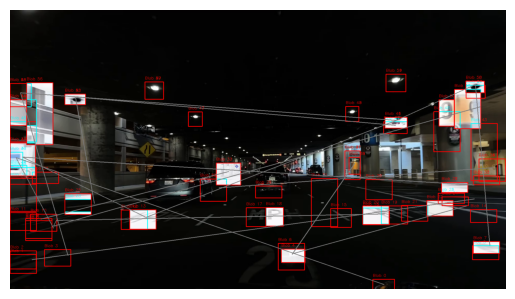

In [54]:
import matplotlib.pyplot as plt

frame = load_video('../data/cars.mp4')
blurred = preprocess_frame(frame)
thresh = get_thresholded_image(blurred)
inverted = invert_image(thresh)
contours = find_contours(inverted)
rects = draw_rectangles(frame.copy(), contours)
partial = apply_partial_effects(rects, contours)
final = draw_lines(partial, contours)

plt.imshow(final)
plt.axis('off')

In [56]:
process_video('../data/cars.mp4', '../Output_Videos/First_Lap.mp4')

Video saved successfully to: ../Output_Videos/First_Lap.mp4


In [57]:
process_video('../data/leaves.mp4', '../Output_Videos/wedonlose.mp4')

Video saved successfully to: ../Output_Videos/wedonlose.mp4
